In [300]:
import numpy as np
from matplotlib import pyplot as plt
import corner
import lal
import lalsimulation
import pandas as pd

gamma_E=0.57721566 # Euler-Mascheroni constant
c=3e8 # SI
G=6.67e-11 # SI
Msolar=2e30 # kg
Mpc = 3.086e22 # meters

# Define Fisher Matrix

## Useful auxiliary functions

In [2]:
def calc_ampl(params,f):
    dist=params['dist']
    alpha=params['alpha']
    delta=params['delta']
    iota=params['iota']
    Mc=params['Mc']
    if alpha==None:
        # assume optimal orientation and sky direction... F+=1, Fx=0 (?)
        ampl=np.sqrt(5/24) * G**2/c**5 * Mc**(5/6) * (G*f/c**3)**(-7/6)/(np.pi**(2/3)*dist)
    return ampl

def calc_Mtot(params):
    Mc=params['Mc']
    eta=params['eta']
    return Mc*eta**(-3/5)

def calc_v(params,f):
    Mtot=calc_Mtot(params)
    eta=params['eta']
    return (G*Mtot*np.pi*f/c**3)**(1/3)

def calc_fisco(params):
    Mtot=calc_Mtot(params)
    return c**3/(6**(3/2)*np.pi*G*Mtot)

## Define phase of waveform

In [3]:
# Waveform definition

# h = F+ h+ + Fx hx
# h+ = A+ e^(-i psi)
# hx = Ax e^(-i psi)
# A+ and Ax are defined in the calc_ampl function above
# We define psi below

# psi = 2*pi*f*tc - phic - np.pi/4 + psi_PP + psi_Tidal

# First define the point particle part of the phase
# This is using my notes with is some mix of 0907.0700 and Flanagan+Hinderer 0709.1915

# psi_PP=3/128 *(np.pi*f*Mc)**(-5/3) * (power_terms + log_terms)
# where
# power_terms = np.sum(A[m,n,a,b]*v**m*eta**n*beta**a*sigma**b) 
# log_terms   = np.sum(B[m,n]*v**m*eta**n*np.log(C[n]*v))
# (in my notes I wrote eta^m v^n, so to compare code and notes one needs to do the swap m<-->n)


# A, B, and C coefficients come from TaylorF2 up to 3.5 PN
A=np.zeros([7+1,3+1,1+1,1+1])
B=np.zeros([7+1,3+1,1+1,1+1])
C=np.ones([7+1,3+1,1+1,1+1]) # use ones to avoid log(0) -- B=0 will cancel terms we don't want

# power_terms
A[0,0,0,0]=1 # 1
A[2,0,0,0]=20/9*743/336 # v^2
A[2,1,0,0]=20/9*11/4 # v^2 eta
A[3,0,0,0]=-16*np.pi # v^3
A[3,0,1,0]=4 # v^3 beta
A[4,0,0,0]=10*3058673/1016064 # v^4
A[4,1,0,0]=10*5429/1008 # v^4 eta
A[4,2,0,0]=10*617/144 # v^4 eta^2
A[4,0,0,1]=-10 # v^4 sigma
#A[6,0,0,0]= 1158323123653/4694215680-640*np.pi**2/3-6848*gamma_E/21 # v^6
#A[6,1,0,0]= 15335597827/3038192+2255*np.pi**2/12+47324/63-7948/9 # v^6 eta
#A[6,2,0,0]= 76055/1728 # v^6 eta^2
#A[6,3,0,0]= -127825/1296 # v^6 eta^3
#A[7,0,0,0]= 77096675*np.pi/254016 # v^7
#A[7,1,0,0]= 378515*np.pi/1512 # v^7 eta
#A[7,2,0,0]= -74045/756 # v^7 eta^2

# log_terms
# log(v)
#B[0,0,0,0]=38645*np.pi/252
#C[0,0,0,0]=1
# eta log(v)
#B[0,1,0,0]=-65/3
#C[0,1,0,0]=1
# v^6 log(4v)
#B[6,0,0,0]=-6848/21
#C[6,0,0,0]=4

def psi_pp(params,f):
    Mc=params['Mc']
    eta=params['eta']
    beta=params['beta']
    sigma=params['sigma']
    
    v=calc_v(params,f)
    
    power_terms = 0
    log_terms = 0
    # TODO--vectorize
    for m in range(7+1):
        for n in range(3+1):
            for a in range(1+1):
                for b in range(1+1):
                    power_terms=power_terms+A[m,n,a,b]*v**m*eta**n*beta**a*sigma**b
                    log_terms=log_terms+B[m,n,a,b]*v**m*eta**n*beta**a*sigma**b*np.log(C[m,n,a,b]*v)
                    
    psi_pp=3/128 *(G*np.pi*f*Mc/c**3)**(-5/3) * (power_terms+log_terms)



# Next define the tidal part of the phase using 1410.8866 (note x=v^2)
# psi_Tidal = 3/128 *(np.pi*f*Mc)**(-5/3) 
#                * (-39/2 * Lambda_tilde * v^10 
#                + (-3116/64 Lambda_tilde + 6595/364 np.sqrt(1-4*eta) delta_Lambda_Tilde) v^12)

def psi_Tidal(params,f):
    Lambda_tilde=params['Lambda_tilde']
    v=calc_v(params,f)
    
    psi_Tidal = -39/2 * Lambda_tilde * v**10
    
# put it all together to define the phase
def psi(params,f):
    tc=params['tc']
    phic=params['phic']
    return 2*np.pi*f*tc - phic - np.pi/4 + psi_pp[params,f] + psi_Tidal[params,f]


## Define gradients of phase wrt parameters
in other words define 
\begin{equation}
\frac{\partial \psi}{\partial \theta^a} 
\end{equation}
where $\theta^a=\{f_0t_c,\phi_c,{\rm log}M_c,{\rm log}\eta,\beta,\sigma,\tilde\Lambda\}$ and $f_0=f_{\rm isco}$

In [287]:
# Now define the gradients of the phase, which we will need for the fisher matrix

# TODO -- add q as a parameter (can copy/paste the logeta version with eta->eta(q) then multiply by dlogeta/dq)
def grad_phase(params,f,var):
    if var=='f0tc':
        f0=calc_fisco(params)
        #f0=70
        return 2*np.pi*f/f0
    
    if var=='phic':
        return -1
    
    if var=='logMc': 
        Mc=params['Mc']
        eta=params['eta']
        beta=params['beta']
        sigma=params['sigma']
        Lambda_tilde=params['Lambda_tilde']
        v=calc_v(params,f)
        # point particle
        pre_factor= -5/128*(G*np.pi*f*Mc/c**3)**(-5/3)
        power_terms=0
        log_terms=0
        # TODO--vectorize
        for m in range(7+1):
            for n in range(3+1):
                for a in range(1+1):
                    for b in range(1+1):
                        power_terms=power_terms+((1-m/5)*A[m,n,a,b]+B[m,n,a,b])*v**m*eta**n*beta**a*sigma**b
                        log_terms=log_terms+(m*B[m,n,a,b])*v**m*eta**n*beta**a*sigma**b*np.log(C[m,n,a,b]*v)
        grad_logMc_pp = pre_factor*(power_terms+log_terms)
        # tidal
        grad_logMc_Tidal = -39/2 * 10/3 * Lambda_tilde * v**10
        
        #print('v=%e'%v[0])
        #print('pre_factor=%e'%pre_factor[0])
        #print('power_terms=%e'%power_terms[0])
        #print('log_terms=%e'%log_terms[0])
        #print('grad_logMc_pp=%e'%grad_logMc_pp[0])
        #print('grad_logMc_pp=%e'%grad_logMc_pp[0])
        #print('grad_logMc_Tidal=%e'%grad_logMc_Tidal[0])
        
        return grad_logMc_pp+grad_logMc_Tidal
    
    if var=='logeta':    
        Mc=params['Mc']
        eta=params['eta']
        beta=params['beta']
        sigma=params['sigma']
        Lambda_tilde=params['Lambda_tilde']
        v=calc_v(params,f)
        # point particle        
        pre_factor= 3/128*(G*np.pi*f*Mc/c**3)**(-5/3)
        power_terms=0
        log_terms=0
        # TODO--vectorize
        for m in range(7+1):
            for n in range(3+1):
                for a in range(1+1):
                    for b in range(1+1):
                        power_terms=power_terms+((n-m/5)*A[m,n,a,b]-((n+1)/5)*B[m,n,a,b])*v**m*eta**n*beta**a*sigma**b
                        log_terms=log_terms+(n*B[m,n,a,b])*v**m*eta**n*beta**a*sigma**b*np.log(C[m,n,a,b]*v)
        grad_logeta_pp = pre_factor*(power_terms+log_terms)
        
        # tidal
        grad_logeta_Tidal = -39/2 * 10/5 * Lambda_tilde * v**10
        
        return grad_logeta_pp+grad_logeta_Tidal
    
    if var=='q':
        q=params['q']
        params2=params.copy()
        eta=q/(1+q**2)
        params2['eta']=eta
        Dlogeta_Dq = 1/eta * 1/(1+q**2)*(1-2*q/(1+q))
        Dpsi_Dlogeta = grad_phase(params2,f,'logeta')
        return Dpsi_Dlogeta * Dlogeta_Dq
    
    if var=='beta': 
        Mc=params['Mc']
        eta=params['eta']
        beta=params['beta']
        sigma=params['sigma']
        Lambda_tilde=params['Lambda_tilde']
        v=calc_v(params,f)
        # point particle        
        pre_factor= 3/128*(G*np.pi*f*Mc/c**3)**(-5/3)
        power_terms=0
        # TODO--vectorize
        for m in range(7+1):
            for n in range(3+1):
                for a in range(1+1):
                    for b in range(1+1):
                        if a!=0:
                            power_terms=power_terms+(a*A[m,n,a,b])*v**m*eta**n*beta**(a-1)*sigma**b
        return pre_factor*power_terms
    
    if var=='sigma': 
        Mc=params['Mc']
        eta=params['eta']
        beta=params['beta']
        sigma=params['sigma']
        Lambda_tilde=params['Lambda_tilde']
        v=calc_v(params,f)
        # point particle        
        pre_factor= 3/128*(G*np.pi*f*Mc/c**3)**(-5/3)
        power_terms=0
        # TODO--vectorize
        for m in range(7+1):
            for n in range(3+1):
                for a in range(1+1):
                    for b in range(1+1):
                        if b!=0:
                            power_terms=power_terms+(b*A[m,n,a,b])*v**m*eta**n*beta**a*sigma**(b-1)
        return pre_factor*power_terms
    
    if var=='Lambda_tilde':
        Mc=params['Mc']
        pre_factor= 3/128*(G*np.pi*f*Mc/c**3)**(-5/3)
        v=calc_v(params,f)
        return -39/2 * pre_factor * v**10

## Define gradient of waveform
In other words define
\begin{equation}
\frac{\partial h}{\partial \Theta^A}
\end{equation}
where $\Theta^A=\{A,\theta^a\}$

In [5]:
# Define gradient wrt parameters for waveform. Includes amplitude and phase.
def grad_h(params,f,var):
    if var=='logA':
        return calc_ampl(params,f)
    else:
        ampl=calc_ampl(params,f)
        return 1j*ampl*grad_phase(params,f,var)

## Define function to compute PSD

either white noise with a given amplitude, or else read from file
also return the frequency array associated with that psd

In [6]:
# Read in noise curve
def calc_noise_psd(params_noise):
    detector=params_noise['detector']
    if detector=='white':
        h0=params_noise['h0']
        df=params_noise['df']
        fmin=params_noise['fmin']
        fmax=params_noise['fmax']
        freqs=np.arange(fmin,fmax,df)
        psd=(h0*np.ones(freqs.shape))**2
        return freqs,psd
    if detector=='PoissonWillModel':
        S0=(1.29563e-21)**2 # PW say this norm constant is irrelvant. I chose it so d=1Mpc gives SNR~=10
        f0=70
        fmin=10
        fmax=2000
        df=0.01
        freqs=np.arange(fmin,fmax,df)
        psd=1/5*S0*((f0/freqs)**4+2+2*(freqs/f0)**2)
        return freqs,psd
    if detector=='aLIGO':
        input_file='input/CE_ASD_P1600143-v18.dat'
        freqs,aLIGO,ETD,CE,CE_WB,CE_pess=np.loadtxt(input_file,unpack=True)
        psd=aLIGO**2
        return freqs,psd
    if detector=='ET' or detector=='ETD':
        input_file='input/CE_ASD_P1600143-v18.dat'
        freqs,aLIGO,ETD,CE,CE_WB,CE_pess=np.loadtxt(input_file,unpack=True)
        psd=ETD**2
        return freqs,psd      

## Define noise weighted inner product (NWIP)

\begin{equation}
(A|B) = 4 {\rm Re} \int_0^\infty {\rm d}f \frac{A(f) B^\star(f)}{S_n(f)}
\end{equation}

In [7]:
def NW_IP(AA,BB,params_noise,fmax):
    # Noise Weighted Inner Product
    # TODO Interpolate signal freq array to noise freq array
    freqs,Sn=calc_noise_psd(params_noise)
    df=freqs[1]-freqs[0]
    cut=freqs<fmax
    AA=AA[cut]
    BB=BB[cut]
    Sn=Sn[cut]
    return 4*np.real((np.sum(AA*np.conj(BB)/Sn)*df))

## Define SNR
\begin{equation}
{\rm SNR}=\sqrt{(h|h)}
\end{equation}

In [8]:
def calc_SNR(params_signal,params_noise,fmax):
    freqs,Sn=calc_noise_psd(params_noise)
    h=calc_ampl(params_signal,freqs)
    return np.sqrt(NW_IP(h,h,params_noise,fmax))

## Compute the fisher matrix
The Fisher matrix is defined as
\begin{equation}
\Gamma_{ab} = \left(\frac{\partial h}{\partial \Theta^a}\Big|\frac{\partial h}{\partial \Theta^b}\right)
\end{equation}
where $\Theta^a=\{{\rm log}A,t_c,\phi_c,{\rm log}M_c,{\rm log}\eta,\beta,\sigma,\tilde{\Lambda}\}$

We assume optimal orientation/sky location

In [9]:
def FisherMatrix(params_signal,params_noise,params_fisher,verbose=False):
    freqs,Sn=calc_noise_psd(params_noise)    
    fmax=min(max(freqs),calc_fisco(params_signal))

    FM=np.zeros([len(params_fisher),len(params_fisher)])
    for ii,param1 in enumerate(params_fisher):
        for jj,param2 in enumerate(params_fisher):
            AA=grad_h(params_signal,freqs,param1)
            BB=grad_h(params_signal,freqs,param2)
            FM[ii,jj]=NW_IP(AA,BB,params_noise,fmax)
            if verbose:
                print('FM(%u,%u) = %e'%(ii+1,jj+1,FM[ii,jj]))
    return FM

## Function to draw samples from a multi-variate Gaussian with a given covariance matrix

Covariance matrix satisfies
\begin{equation}
\Sigma v = \lambda v
\end{equation}
where $v$ is the eigenvector and $\lambda$ the eigenvalue.

Let $V$ be the matrix whose columns are the eigenvectors $v$. 

$V^T$ is the matrix that maps a vector from original basis to diagonal basis.

$V$ is the matrix that maps a vector from the diagonal basis to the original basis.

After diagonalizing $\Sigma$, the diagonal elements give variances. So square root of diagonal elements give stds.

In [10]:
def draw_samples_Gaussian(cov_matrix,means=None,Nsamples=1):
    # pre-processing: check if user has given means. if not then take means to be zero.
    if means is None:
        means=np.zeros(sigmas.shape)
        
    # diagonalize covariance matrix
    evals,evecs=np.linalg.eigh(cov_matrix)
    
    # draw samples (these are samples of (param-mean))
    ndims=len(evals)
    sigmas=np.sqrt(evals)
    sigmas=np.reshape(sigmas,(len(sigmas),1))
    diag_samples=np.random.randn(ndims,Nsamples)*sigmas
    
    # un-diagonalize samples
    samples=np.dot(evecs,diag_samples)
    
    # add means
    means=np.tile(means,(Nsamples,1)).T
    samples=samples+means
    
    return samples

# Produce samples for N events


## Testing the injection code

First let's generate 1000 events and then make plots of the various NS properties as a check we are doing things right.

We'll fix the distance to 400 Mpc.
We'll choose optimal orientation and sky location.
We'll draw m1 and m2 from a Gaussian distribution with mean=1.33Msun with std=0.09 Msun.
We'll choose the <XX> EOS, and use that to compute Lambda1, Lambda2, Lambda_tilde.
We'll choose spins to be 0 (beta=sigma=0).


In [153]:
NInjections=1000

# EOS (Use MS1 parameters from 1410.8866)
eos_params={}
eos_params['name']='MS1'
eos_params['log_p']=34.858-1 #-1 converts cgs to SI
eos_params['Gamma1']=3.224
eos_params['Gamma2']=3.572
eos_params['Gamma3']=1.325

eos=lalsimulation.SimNeutronStarEOS4ParameterPiecewisePolytrope(eos_params['log_p'],
                                                               eos_params['Gamma1'],
                                                               eos_params['Gamma2'],
                                                               eos_params['Gamma3'])
fam = lalsimulation.CreateSimNeutronStarFamily(eos)
mmax = lalsimulation.SimNeutronStarMaximumMass(fam)/lal.MSUN_SI
h_max = lalsimulation.SimNeutronStarEOSMaxPseudoEnthalpy(eos)


# Parameters that we fix
d_inj=400*Mpc
beta_inj=0
sigma_inj=0

# arrays for parameters we want to store
m1_inj=np.zeros(NInjections)
m2_inj=np.zeros(NInjections)
R1_inj=np.zeros(NInjections)
R2_inj=np.zeros(NInjections)
Lambda1_inj=np.zeros(NInjections)
Lambda2_inj=np.zeros(NInjections)

# generate NS parameters
for ii in range(NInjections):
    # Draw masses
    #m1 = (np.random.randn()*0.09 + 1.33)
    #m2 = (np.random.randn()*0.09 + 1.33)
    ma=np.random.rand()*2.25+0.4
    mb=np.random.rand()*2.25+0.4
    
    m1=max(ma,mb)
    m2=min(ma,mb)

    
    # Compute radius using eos
    r1_SI = lalsimulation.SimNeutronStarRadius(m1*lal.MSUN_SI, fam)
    r2_SI = lalsimulation.SimNeutronStarRadius(m2*lal.MSUN_SI, fam)
    
    
    # Compute Love number k2 using eos
    k2_1=lalsimulation.SimNeutronStarLoveNumberK2(m1*lal.MSUN_SI, fam)
    k2_2=lalsimulation.SimNeutronStarLoveNumberK2(m2*lal.MSUN_SI, fam)
    
    # Compute Lambda1 and Lambda2 using universal relation (?)
    Lambda1=(2./3.)*k2_1*( (lal.C_SI**2*r1_SI)/(lal.G_SI*m1*lal.MSUN_SI) )**5
    Lambda2=(2./3.)*k2_2*( (lal.C_SI**2*r2_SI)/(lal.G_SI*m2*lal.MSUN_SI) )**5
    
    # Store results
    m1_inj[ii]=m1
    m2_inj[ii]=m2
    R1_inj[ii]=r1_SI/1e3 # Convert to km
    R2_inj[ii]=r2_SI/1e3 # Convert to km
    Lambda1_inj[ii]=Lambda1
    Lambda2_inj[ii]=Lambda2

Mc_inj = (m1_inj*m2_inj)**(3/5)/(m1_inj+m2_inj)**(1/5)
eta_inj=(m1_inj*m2_inj)/(m1_inj+m2_inj)**2
Mtot_inj=m1_inj+m2_inj
q_inj=m2_inj/m1_inj
lambda1_inj=Lambda1_inj * (G*m1_inj*Msolar/c**2)**5/G
lambda2_inj=Lambda2_inj * (G*m2_inj*Msolar/c**2)**5/G
Lambda_tilde_inj=8/13*( (1+7*eta_inj-31*eta_inj**2)*(Lambda1_inj+Lambda2_inj) 
                      +np.sqrt(1-4*eta_inj)*(1+9*eta_inj-11*eta_inj**2)*(Lambda1_inj-Lambda2_inj))

Text(0.5, 1.0, 'MS1')

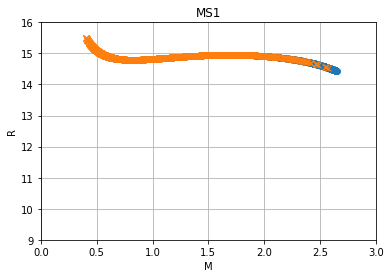

In [154]:
plt.plot(m1_inj,R1_inj,'o')
plt.plot(m2_inj,R2_inj,'x')

plt.xlabel('M')
plt.ylabel('R')
plt.ylim(9,16)
plt.xlim(0,3)
plt.grid()
plt.title(eos_params['name'])

Text(0.5, 1.0, 'MS1')

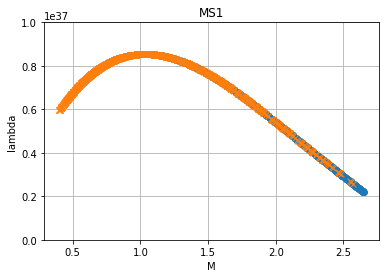

In [155]:
conv=1e3*(100)**2 #converts SI (kg m^2 s^2) to cgs (g cm^2 s^2)

plt.plot(m1_inj,lambda1_inj*conv,'o')
plt.plot(m2_inj,lambda2_inj*conv,'x')

plt.xlabel('M')
plt.ylabel('lambda')
plt.grid()

plt.ylim(0,1e37)
plt.title(eos_params['name'])

(array([16., 24., 37., 45., 42., 55., 61., 41., 45., 41., 48., 68., 66.,
        53., 65., 55., 55., 57., 63., 63.]),
 array([0.16229335, 0.20417816, 0.24606297, 0.28794779, 0.3298326 ,
        0.37171741, 0.41360222, 0.45548703, 0.49737184, 0.53925665,
        0.58114147, 0.62302628, 0.66491109, 0.7067959 , 0.74868071,
        0.79056552, 0.83245034, 0.87433515, 0.91621996, 0.95810477,
        0.99998958]),
 <a list of 20 Patch objects>)

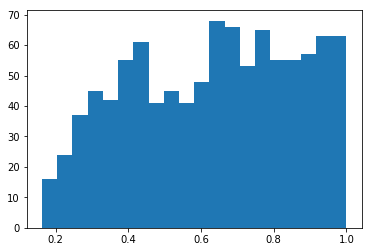

In [156]:
plt.hist(q_inj,bins=20)

(array([ 9., 26., 38., 32., 33., 65., 71., 72., 77., 82., 83., 81., 84.,
        63., 49., 42., 41., 17., 24., 11.]),
 array([0.94215752, 1.1541934 , 1.36622928, 1.57826516, 1.79030104,
        2.00233692, 2.2143728 , 2.42640868, 2.63844456, 2.85048044,
        3.06251632, 3.2745522 , 3.48658808, 3.69862396, 3.91065984,
        4.12269571, 4.33473159, 4.54676747, 4.75880335, 4.97083923,
        5.18287511]),
 <a list of 20 Patch objects>)

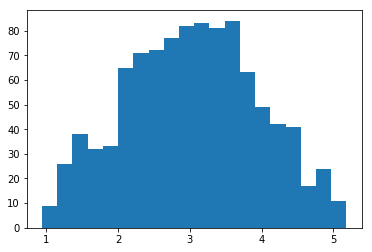

In [157]:
plt.hist(Mtot_inj,bins=20)

Text(0, 0.5, 'Counts')

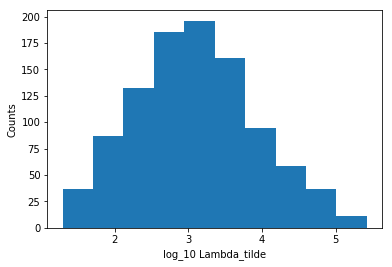

In [160]:
plt.hist(np.log(Lambda_tilde_inj)/np.log(10),bins=10)
plt.xlabel('log_10 Lambda_tilde')
plt.ylabel('Counts')

## Make posterior samples for 10 events with ET


### First generate injection parameters

In [289]:
NInjections=10

# EOS (Use MS1 parameters from 1410.8866)
eos_params={}
eos_params['name']='MS1'
eos_params['log_p']=34.858-1 #-1 converts cgs to SI
eos_params['Gamma1']=3.224
eos_params['Gamma2']=3.572
eos_params['Gamma3']=1.325

eos=lalsimulation.SimNeutronStarEOS4ParameterPiecewisePolytrope(eos_params['log_p'],
                                                               eos_params['Gamma1'],
                                                               eos_params['Gamma2'],
                                                               eos_params['Gamma3'])
fam = lalsimulation.CreateSimNeutronStarFamily(eos)
mmax = lalsimulation.SimNeutronStarMaximumMass(fam)/lal.MSUN_SI
h_max = lalsimulation.SimNeutronStarEOSMaxPseudoEnthalpy(eos)


# Parameters that we fix
d_inj=40*Mpc
beta_inj=0
sigma_inj=0

# arrays for parameters we want to store
m1_inj=np.zeros(NInjections)
m2_inj=np.zeros(NInjections)
Lambda1_inj=np.zeros(NInjections)
Lambda2_inj=np.zeros(NInjections)

# generate NS parameters
for ii in range(NInjections):
    # Draw masses
    #m1 = (np.random.randn()*0.09 + 1.33)
    #m2 = (np.random.randn()*0.09 + 1.33)
    ma=np.random.rand()*2.25+0.4
    mb=np.random.rand()*2.25+0.4
    
    m1=max(ma,mb)
    m2=min(ma,mb)

    
    # Compute radius using eos
    r1_SI = lalsimulation.SimNeutronStarRadius(m1*lal.MSUN_SI, fam)
    r2_SI = lalsimulation.SimNeutronStarRadius(m2*lal.MSUN_SI, fam)
    
    
    # Compute Love number k2 using eos
    k2_1=lalsimulation.SimNeutronStarLoveNumberK2(m1*lal.MSUN_SI, fam)
    k2_2=lalsimulation.SimNeutronStarLoveNumberK2(m2*lal.MSUN_SI, fam)
    
    # Compute Lambda1 and Lambda2 using universal relation (?)
    Lambda1=(2./3.)*k2_1*( (lal.C_SI**2*r1_SI)/(lal.G_SI*m1*lal.MSUN_SI) )**5
    Lambda2=(2./3.)*k2_2*( (lal.C_SI**2*r2_SI)/(lal.G_SI*m2*lal.MSUN_SI) )**5
    
    # Store results
    m1_inj[ii]=m1
    m2_inj[ii]=m2
    Lambda1_inj[ii]=Lambda1
    Lambda2_inj[ii]=Lambda2

Mc_inj = (m1_inj*m2_inj)**(3/5)/(m1_inj+m2_inj)**(1/5)
eta_inj=(m1_inj*m2_inj)/(m1_inj+m2_inj)**2
q_inj=m2_inj/m1_inj
Lambda_tilde_inj=8/13*( (1+7*eta_inj-31*eta_inj**2)*(Lambda1_inj+Lambda2_inj) 
                      +np.sqrt(1-4*eta_inj)*(1+9*eta_inj-11*eta_inj**2)*(Lambda1_inj-Lambda2_inj))

In [312]:
params_signal['q']=1
for ii in range(len(params_fisher)):
    print('%u: %s'%(ii+1,params_fisher[ii]))
FM=FisherMatrix(params_signal,params_noise,params_fisher,verbose=True)

fref=20
means=np.zeros(len(params_fisher))
means[0]=np.log(calc_ampl(params_signal,fref)) # logA
means[1]=0 # f0tc
means[2]=0 # phic
means[3]=np.log(params_signal['Mc']) # logMc
means[4]=params_signal['q'] # q
means[5]=params_signal['sigma'] # sigma
means[6]=params_signal['beta'] # beta
means[7]=params_signal['Lambda_tilde'] # Lambda_tilde

cov_matrix=np.linalg.inv(FM)
samples=draw_samples_Gaussian(cov_matrix,means=means,Nsamples=Nsamples)

corner.corner(samples.T,labels=params_fisher)
plt.show()

1: logA
2: f0tc
3: phic
4: logMc
5: q
6: sigma
7: beta
8: Lambda_tilde
FM(1,1) = 3.721316e+05
FM(1,2) = 0.000000e+00
FM(1,3) = 0.000000e+00
FM(1,4) = 0.000000e+00
FM(1,5) = 0.000000e+00
FM(1,6) = 0.000000e+00
FM(1,7) = 0.000000e+00
FM(1,8) = 0.000000e+00
FM(2,1) = 0.000000e+00
FM(2,2) = 3.686721e+03
FM(2,3) = -1.897518e+04
FM(2,4) = -1.166856e+09
FM(2,5) = 0.000000e+00
FM(2,6) = -2.072988e+05
FM(2,7) = 1.023715e+06
FM(2,8) = -2.870282e+00
FM(3,1) = 0.000000e+00
FM(3,2) = -1.897518e+04
FM(3,3) = 3.721316e+05
FM(3,4) = 4.316398e+10
FM(3,5) = 0.000000e+00
FM(3,6) = 5.174485e+06
FM(3,7) = -2.997768e+07
FM(3,8) = 5.425689e+00
FM(4,1) = 0.000000e+00
FM(4,2) = -1.166856e+09
FM(4,3) = 4.316398e+10
FM(4,4) = 6.881405e+15
FM(4,5) = 0.000000e+00
FM(4,6) = 6.620144e+11
FM(4,7) = -4.129221e+12
FM(4,8) = 1.206581e+05
FM(5,1) = 0.000000e+00
FM(5,2) = 0.000000e+00
FM(5,3) = 0.000000e+00
FM(5,4) = 0.000000e+00
FM(5,5) = 0.000000e+00
FM(5,6) = 0.000000e+00
FM(5,7) = 0.000000e+00
FM(5,8) = 0.000000e+00
F

LinAlgError: Singular matrix

### Then generate a fisher matrix for each injection and draw samples

TO DO...

(1) apply cuts.
first we should check that the injected neutron stars obey all of the constraints (causality, maximum mass, ...)
then we should convert eta to q
then we should impose cuts on the samples that:
- 0<=q<=1
- phi_c < 2pi (?)
- beta<=1

In [295]:
params_noise['detector']='ET'

FMs={}
all_samples={}

for ii in range(NInjections):
    # extrinsic parameters
    params_signal['dist']=d_inj
    params_signal['iota']=None
    params_signal['alpha']=None
    params_signal['delta']=None
    # intrinsic parameters
    params_signal['Mc']=Mc_inj[ii]*Msolar
    params_signal['eta']=eta_inj[ii]
    params_signal['q']=q_inj[ii]
    params_signal['sigma']=0
    params_signal['beta']=0
    params_signal['Lambda_tilde']=Lambda_tilde_inj[ii]
    
    
    params_fisher=['logA','f0tc','phic','logMc','q','sigma','beta','Lambda_tilde']
    
    print('SNR=%f'%calc_SNR(params_signal,params_noise,calc_fisco(params_signal)))

    
    FM=FisherMatrix(params_signal,params_noise,params_fisher)
    Nsamples=10000

    fref=20
    means=np.zeros(len(params_fisher))
    means[0]=np.log(calc_ampl(params_signal,fref)) # logA
    means[1]=0 # f0tc
    means[2]=0 # phic
    means[3]=np.log(params_signal['Mc']) # logMc
    means[4]=params_signal['q'] # q
    means[5]=params_signal['sigma'] # sigma
    means[6]=params_signal['beta'] # beta
    means[7]=params_signal['Lambda_tilde'] # Lambda_tilde

    cov_matrix=np.linalg.inv(FM)
    evals,evecs=np.linalg.eigh(cov_matrix)
    samples=draw_samples_Gaussian(cov_matrix,means=means,Nsamples=Nsamples)
    
    FMs[ii]=FM
    all_samples[ii]=samples

SNR=748.423596
SNR=689.974984
SNR=565.883068
SNR=888.108956
SNR=435.607681
SNR=1055.946324
SNR=1102.995116
SNR=623.819324
SNR=833.100887
SNR=610.025924


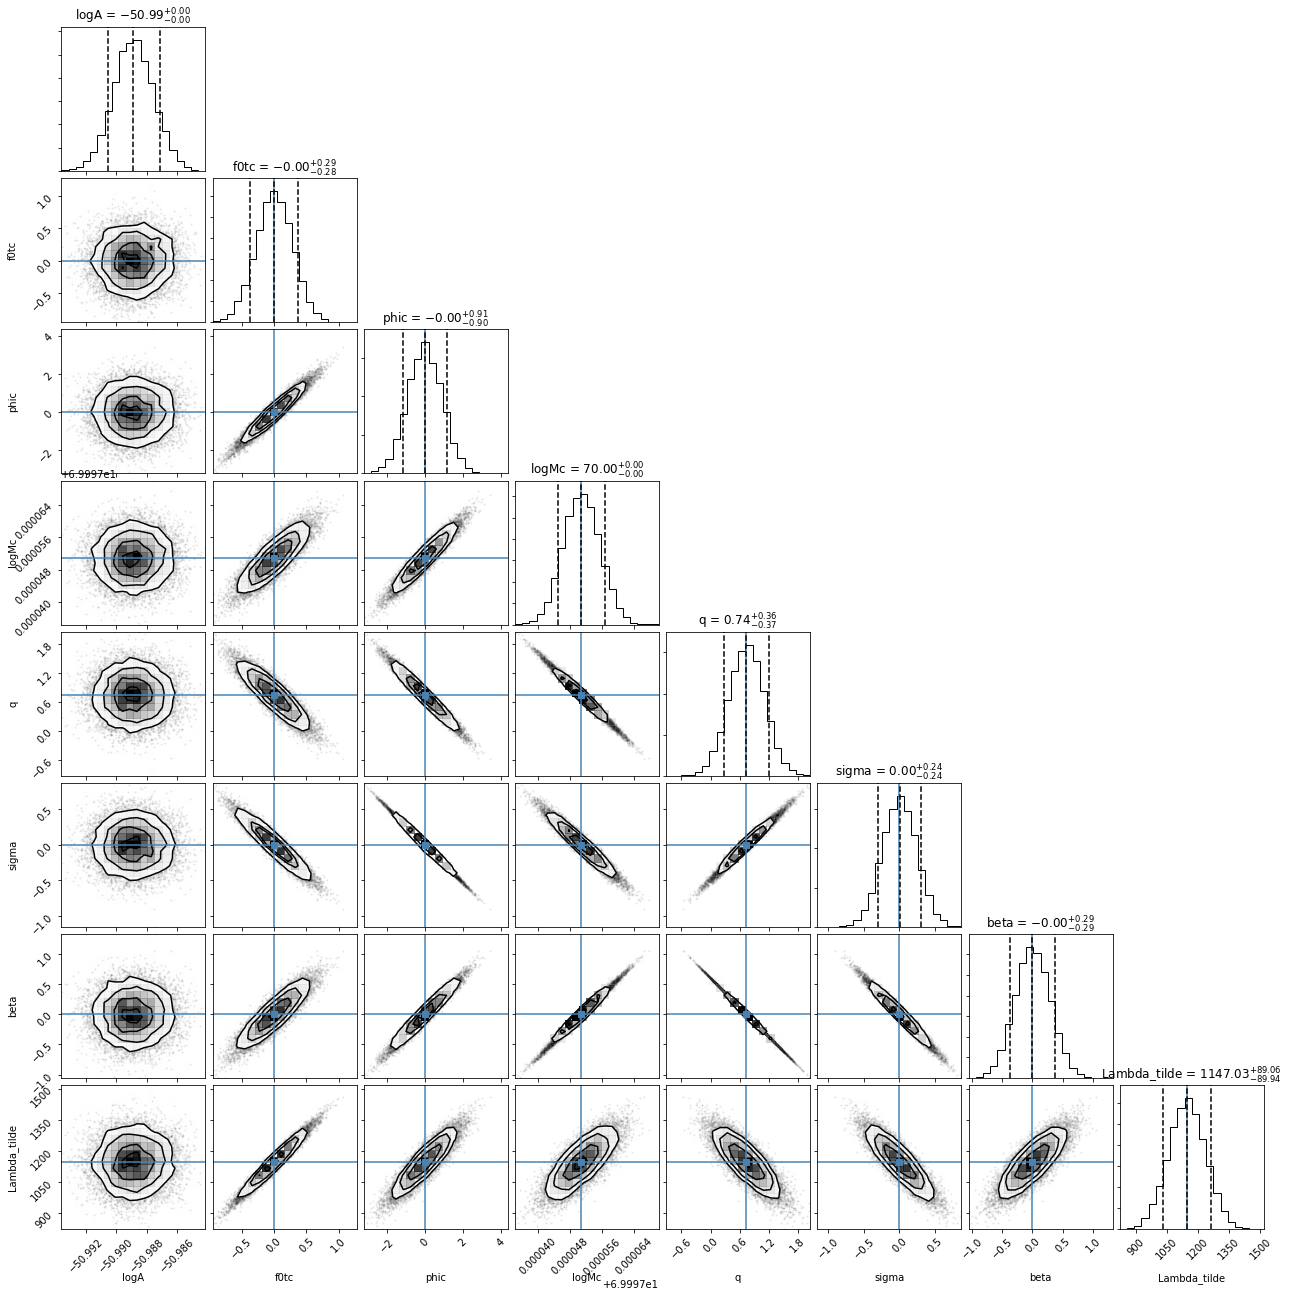

In [296]:
means[0]=None # logA
means[1]=0 # f0tc
means[2]=0 # phic
means[3]=np.log(Mc_inj[0]*Msolar) # logMc
means[4]=q_inj[0]
means[5]=0 # sigma
means[6]=0 # beta
means[7]=Lambda_tilde_inj[0] # Lambda_tilde

corner.corner(all_samples[0].T,labels=params_fisher,truths=means,quantiles=[0.1,0.5,0.9],show_titles=True,title_fmt='2.2f')

plt.show()

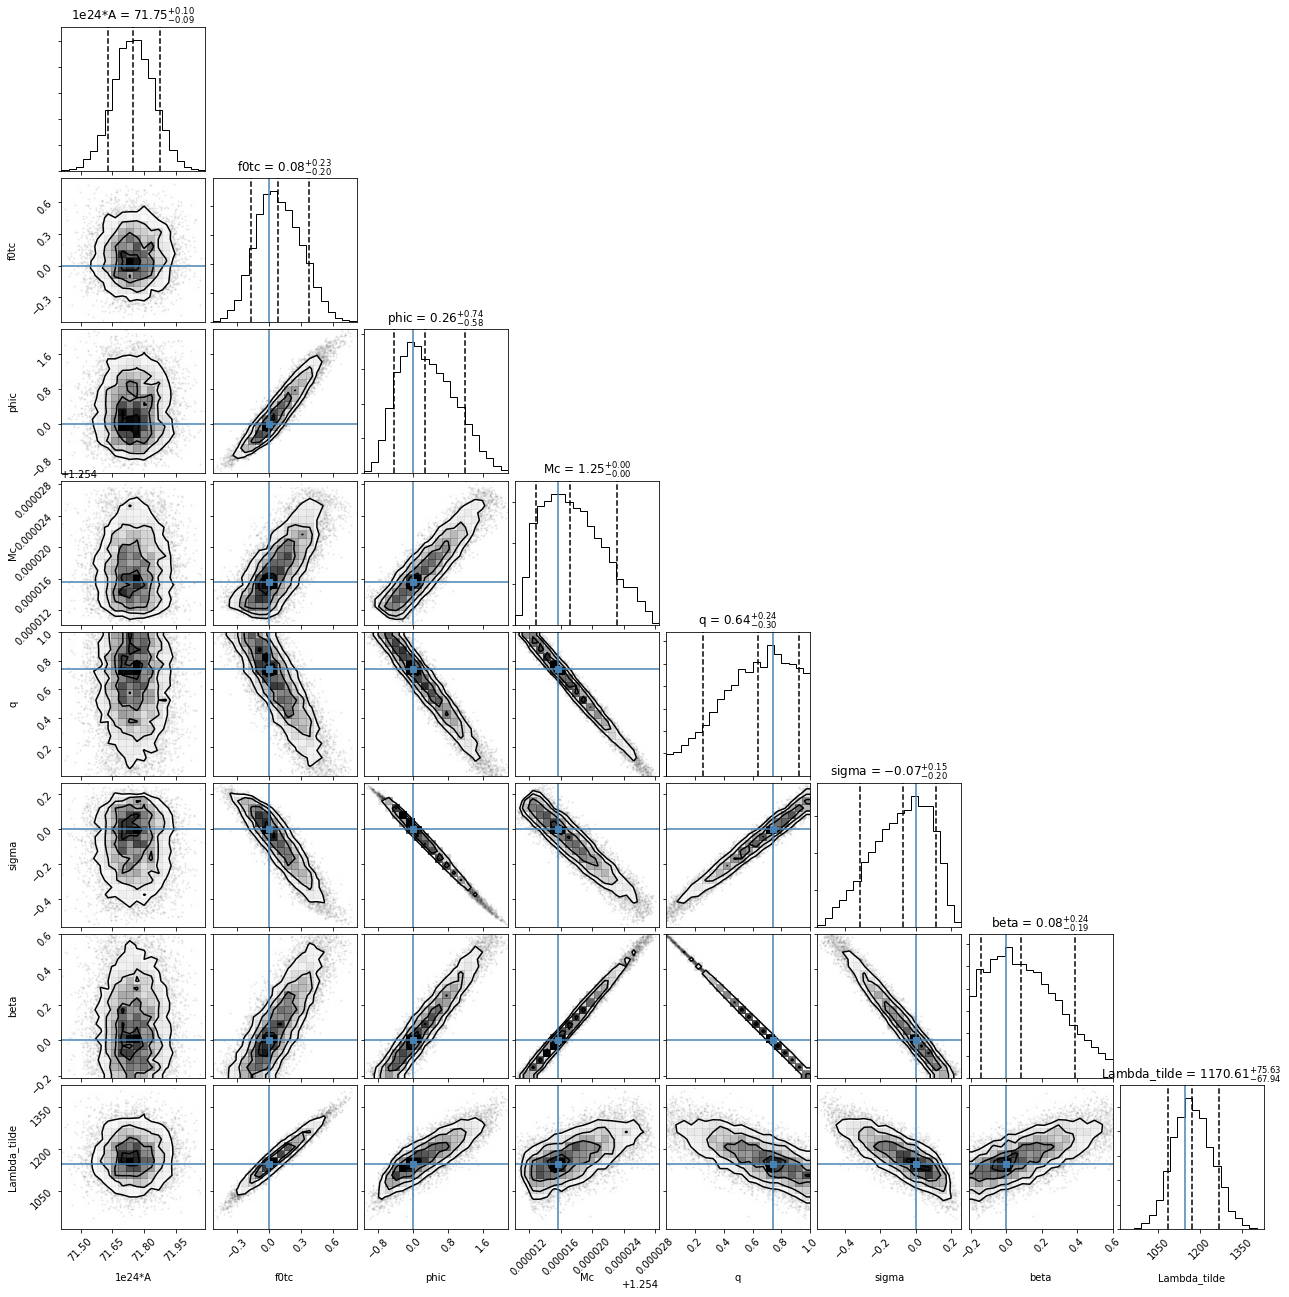

Mc_inj=1.254016
q_inj=0.743104
Lambda_tilde_inj=1146.627436


In [297]:
samples=all_samples[0]

# correct samples -- ie change units to convenient values
samples_corr=np.copy(samples)
samples_corr[0,:]=np.exp(samples[0,:])*1e24
samples_corr[3,:]=np.exp(samples[3,:])/Msolar
qs=samples[4,:]
cut=(qs<=1)*(qs>=0)
samples_corr=samples_corr[:,cut]

means[0]=None # logA
means[1]=0 # f0tc
means[2]=0 # phic
means[3]=Mc_inj[0] # Mc
means[4]=q_inj[0] # q
means[5]=0 # sigma
means[6]=0 # beta
means[7]=Lambda_tilde_inj[0] # Lambda_tilde

params_fisher_corr=['1e24*A','f0tc','phic','Mc','q','sigma','beta','Lambda_tilde']
corner.corner(samples_corr.T,labels=params_fisher_corr,truths=means,quantiles=[0.1,0.5,0.9],show_titles=True,title_fmt='2.2f')
plt.show()

print('Mc_inj=%f'%(Mc_inj[0]))
print('q_inj=%f'%q_of_eta(eta_inj[0]))
print('Lambda_tilde_inj=%f'%Lambda_tilde_inj[0])

(0, 5000)

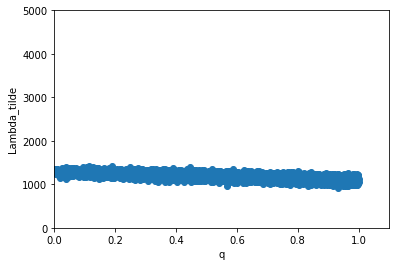

In [298]:
Mc_samps=samples_corr[3,:]
q_samps=samples_corr[4,:]
Lambda_tilde_samps=samples_corr[7,:]

plt.scatter(q_samps,Lambda_tilde_samps)
plt.xlabel('q')
plt.ylabel('Lambda_tilde')

plt.xlim(0,1.1)
plt.ylim(0,5000)

In [318]:
samps={}
samps['mc']=Mc_samps
samps['q']=q_samps
samps['lam_tilde']=Lambda_tilde_samps
dataf=pd.DataFrame(samps)
dataf.to_csv('my_samps.csv',index=False)

- Try with other EOSs 
- To plot samples on M-R plane, need the fits from Yagi et al's papers. Gives you delta_Lambda from Lambda_tilde and q (so you get L1 and L2), then gives you R from Lambda and M
- Save samples in csv format using pandas. Try running Ben's code.
- Fisher matrix is singular (in terms of q) for q=1.

- Constraints on NS
   - Prior bounds
      - 0.5<m1,2<3.2
      - 0<q<1
      - 33.6 < logp <= 35.5 (cgs)
      - 1.5 <= G1,G2,G3 <= 5.0
   - EOS must match known nuclear physics at low pressure
      - p <= plow * (rho1/rho1_low)^G1, where:
         - p = 10^logp
         - rho1_low=2.62780487e12 (cgs units)
         - rho1=10^14.7 (cgs)
         - k_low = 3.593885515256112e13 (cgs)
         - G_low = 1.35692395
         - p_low = k_low * rho_low^Glow
   - Consistency with EM observations
      - Mmax(EOS)>1.93
   - Stable 
      - m1,m2<Mmax(EOS)
   - Causality
      - cs(m,EOS)<=1

- Make my own version of Ben's code.
   - Step 0: Add auxiliary functions... m1 and m2 from Mc and q, others?
   - Step 1: Construct pseudolikelihood by applying KDE to samples of LT, q
   - Step 2: Construct prior: for each set of EOS params (logp,G1,G2,G3) and NS params (q,Mc), check if BNS ok. 
   - Step 3: Construct likelihood: We assume Mc is fixed for each event to the mean. We sample in q. We also sample in EOS params. Given q, Mc, and EOS params, we can construct Lambda. Then we can obtain the value of the likelihood by querying the pseudolikelihood for the values of q and Lambda. For one event, we only have one Mc and q. For N events, we have N Mcs and Nqs, and sum the log likelihoods.
   - Step 4: Construct posterior as prior * likelihood (log post = log prior + log likelihood)
   - Step 5: Set up emcee run. Note this requires setting up walkers. The parameters are q and EOS params.
   - Step 6: Run emcee.
   - Step 7: Post-process results... Plot the chains, plot the 

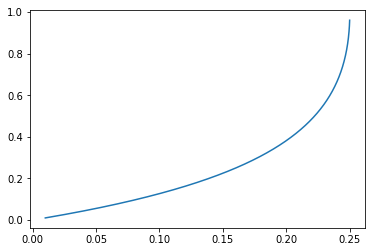

In [232]:
def q_of_eta(eta):
    return 1/(2*eta) * (1 - 2*eta - np.sqrt(1 - 4*eta))

etas=np.arange(0.01,0.25,0.0001)
qs=q_of_eta(etas)
plt.plot(etas,qs)

# Demonstrate method with a specific example

## Compute Fisher matrix for a specific example

Define noise and signal properties and compute fisher matrix

In [11]:
params_noise={}
params_signal={}

params_noise['detector']='aLIGO'
# these parameters only relevant if you choose white noise
params_noise['df']=0.1
params_noise['fmin']=20
params_noise['fmax']=1000
params_noise['h0']=1e-21

# extrinsic parameters
params_signal['dist']=40*Mpc
params_signal['iota']=None
params_signal['alpha']=None
params_signal['delta']=None
# intrinsic parameters
params_signal['Mc']=1.4 * Msolar * 2**(-1/5)
params_signal['eta']=0.25
params_signal['sigma']=0.1
params_signal['beta']=0.1
params_signal['Lambda_tilde']=100


params_fisher=['logA','f0tc','phic','logMc','logeta','sigma','beta','Lambda_tilde']

FM=FisherMatrix(params_signal,params_noise,params_fisher)

## Draw samples from the example Fisher matrix

Also make some plots to show relationships between parameters

Remember that
\begin{equation}
\Sigma=\Gamma^{-1}
\end{equation}
where $\Sigma$ is the covariance matrix and $\Gamma$ is the Fisher matrix

We can draw the deviations from the mean value from a multi-variate gaussian with covariance matrix $\Sigma$
\begin{equation}
\Delta^a = \theta^a - \bar{\theta}^a
\end{equation}

We can also estimate the error in parameter $\theta^a$ by
\begin{equation}
\sigma_a = \sqrt{\Sigma_{aa}} = \sqrt{\Gamma^{-1}_{aa}}
\end{equation}

In [12]:
Nsamples=10000

fref=20
means=np.zeros(len(params_fisher))
means[0]=np.log(calc_ampl(params_signal,fref)) # logA
means[1]=0 # f0tc
means[2]=0 # phic
means[3]=np.log(params_signal['Mc']) # logMc
means[4]=np.log(params_signal['eta']) # logeta
means[5]=params_signal['sigma'] # sigma
means[6]=params_signal['beta'] # beta
means[7]=params_signal['Lambda_tilde'] # Lambda_tilde

cov_matrix=np.linalg.inv(FM)

samples=draw_samples_Gaussian(cov_matrix,means=means,Nsamples=Nsamples)

In [13]:
snr=calc_SNR(params_signal,params_noise,calc_fisco(params_signal))
print('SNR=%f'%snr)

for ii,p in enumerate(params_fisher):
    print('%s\tmu=%e,sigma=%e'%(p,means[ii],np.sqrt(cov_matrix[ii,ii])))

SNR=27.815727
logA	mu=-5.101261e+01,sigma=3.595088e-02
f0tc	mu=0.000000e+00,sigma=4.995373e+00
phic	mu=0.000000e+00,sigma=2.349530e+01
logMc	mu=6.996854e+01,sigma=2.736742e-04
logeta	mu=-1.386294e+00,sigma=4.774391e-01
sigma	mu=1.000000e-01,sigma=7.573002e+00
beta	mu=1.000000e-01,sigma=9.766058e-01
Lambda_tilde	mu=1.000000e+02,sigma=1.299811e+03


In [14]:
# correct samples -- ie change units to convenient values
samples_corr=samples
samples_corr[0,:]=np.exp(samples[0,:])
samples_corr[3,:]=np.exp(samples[3,:])/Msolar
samples_corr[4,:]=np.exp(samples[4,:])

params_fisher_corr=['hc','tc','phic','Mc','eta','sigma','beta','Lambda_tilde']

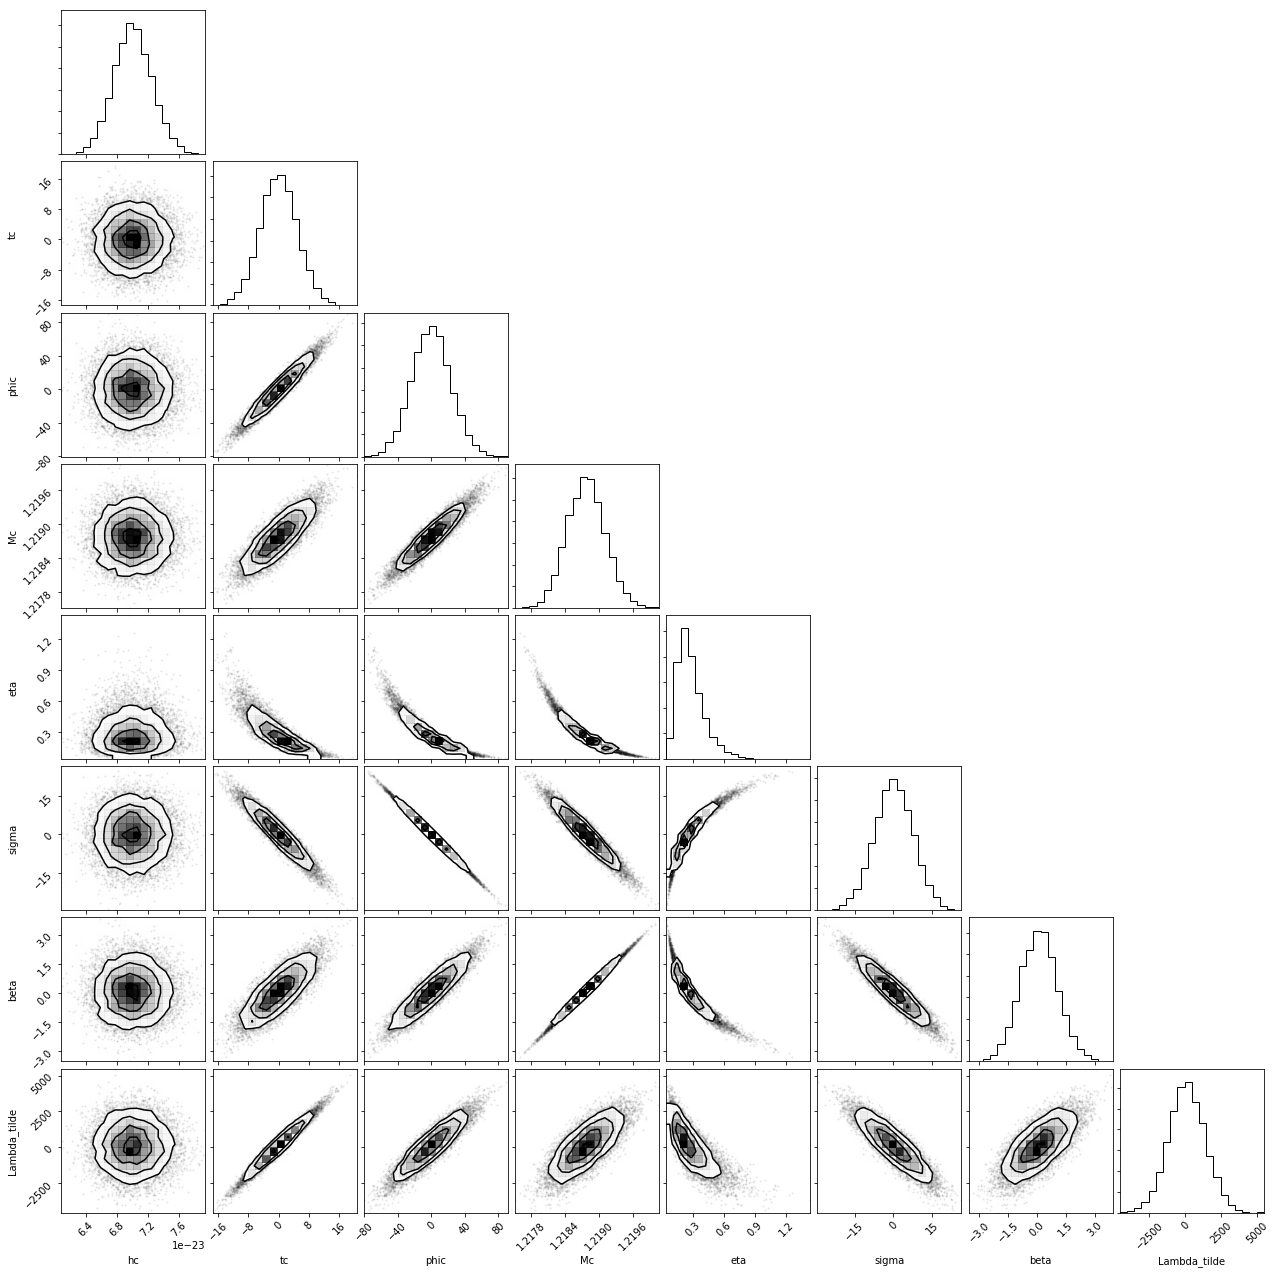

In [15]:
corner.corner(samples_corr.T,labels=params_fisher_corr)
plt.show()

# Tests

## Testing code to draw samples from Gaussian

In [16]:
cov_test=np.array([[20**2,0],[0,1]])
means_test=[1e4,-10]
samples_test=draw_samples_Gaussian(cov_test,means=means_test,Nsamples=10000)

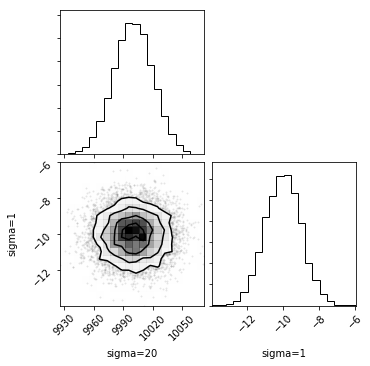

In [17]:
corner.corner(samples_test.T,labels=['sigma=20','sigma=1'])
plt.show()

## Plot signal and noise

FISCO=1565.572395 Hz
SNR=27.815727


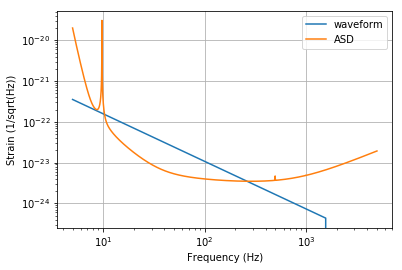

In [18]:
freqs,Sn=calc_noise_psd(params_noise)
hf=calc_ampl(params_signal,freqs)
cut=freqs>calc_fisco(params_signal)
hf[cut]=0

plt.loglog(freqs,hf,label='waveform')
plt.loglog(freqs,np.sqrt(Sn),label='ASD')
plt.legend()
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain (1/sqrt(Hz))')

snr=calc_SNR(params_signal,params_noise,calc_fisco(params_signal))
print('FISCO=%f Hz'%calc_fisco(params_signal))
print('SNR=%f'%snr)

plt.show()

## Check against Poisson+Will

In [19]:
# PW have expressions for grad_h and for Fisher. Can try to reproduce.

In [20]:
def grad_h_PW(params,f,var):
    if var=='logA':
        ampl=calc_ampl(params,f)
        return ampl
    if var=='f0tc':
        ampl=calc_ampl(params,f)
        f0=calc_fisco(params)
        return 2*np.pi*1j*(f/f0)*ampl
    if var=='phic':
        ampl=calc_ampl(params,f)
        return -1j*ampl
    if var=='logMc':
        Mc=params['Mc']
        eta=params['eta']
        beta=params['beta']
        sigma=params['sigma']
        ampl=calc_ampl(params,f)
        v=calc_v(params,f)
        A4=4/3*(743/336+11/4*eta)
        B4=8/5*(4*np.pi-beta)
        C4=2*(3058673/1016064+5429/1008*eta+617/144*eta**2-sigma)
        return -5*1j/128*(G*np.pi*Mc*f/c**3)**(-5/3)*(1+A4*v**2-B4*v**3+C4*v**4)*ampl
    if var=='logeta':
        Mc=params['Mc']
        eta=params['eta']
        beta=params['beta']
        sigma=params['sigma']
        ampl=calc_ampl(params,f)
        v=calc_v(params,f)
        A5=743/168-33/4*eta
        B5=27/5*(4*np.pi-beta)
        C5=18*(3058673/1016064-5429/4032*eta-617/96*eta**2-sigma)
        return -1j/96*(G*np.pi*Mc*f/c**3)**(-5/3)*(A5*v**2-B5*v**3+C5*v**4)*ampl
    if var=='beta':
        Mc=params['Mc']
        eta=params['eta']
        ampl=calc_ampl(params,f)
        return 3*1j/32*eta**(-3/5)*(G*np.pi*Mc*f/c**3)**(-2/3)*ampl
    if var=='sigma':
        Mc=params['Mc']
        eta=params['eta']
        ampl=calc_ampl(params,f)
        return -15*1j/64*eta**(-4/5)*(G*np.pi*Mc*f/c**3)**(-1/3)*ampl

In [21]:
# extrinsic parameters
params_signal['dist']=1*Mpc
params_signal['iota']=None
params_signal['alpha']=None
params_signal['delta']=None
# intrinsic parameters
params_signal['Mc']=1.4 * Msolar * 2**(-1/5)
params_signal['eta']=0.25
params_signal['sigma']=0
params_signal['beta']=0
params_signal['Lambda_tilde']=0

params_fisher=['logA','f0tc','phic','logMc','logeta','beta','sigma']

In [22]:
# Check the gradients

f=24.5

for var in params_fisher:
    print('Gradient wrt %s....'%var)
    print('\tMe: %e+%e*i'%(grad_h(params_signal,f,var).real,grad_h(params_signal,f,var).imag))
    print('\tPW: %e+%e*i'%(grad_h_PW(params_signal,f,var).real,grad_h_PW(params_signal,f,var).imag))

Gradient wrt logA....

	Me: 2.211767e-21+0.000000e+00*i

	PW: 2.211767e-21+0.000000e+00*i

Gradient wrt f0tc....

	Me: 0.000000e+00+2.174765e-22*i

	PW: 0.000000e+00+2.174765e-22*i

Gradient wrt phic....

	Me: -0.000000e+00+-2.211767e-21*i

	PW: 0.000000e+00+-2.211767e-21*i

Gradient wrt logMc....

	Me: -0.000000e+00+-3.174486e-17*i

	PW: 0.000000e+00+-3.174486e-17*i

Gradient wrt logeta....

	Me: 0.000000e+00+3.585542e-19*i

	PW: 0.000000e+00+3.585542e-19*i

Gradient wrt beta....

	Me: 0.000000e+00+7.954142e-20*i

	PW: 0.000000e+00+7.954142e-20*i

Gradient wrt sigma....

	Me: -0.000000e+00+-2.030589e-20*i

	PW: 0.000000e+00+-2.030589e-20*i



In [23]:
params_noise['detector']='PoissonWillModel'
params_fisher=['logA','f0tc','phic','logMc','logeta','beta']

FM=FisherMatrix(params_signal,params_noise,params_fisher,verbose=True)

FM(1,1) = 9.999419e+01
FM(1,2) = 0.000000e+00
FM(1,3) = 0.000000e+00
FM(1,4) = 0.000000e+00
FM(1,5) = 0.000000e+00
FM(1,6) = 0.000000e+00
FM(2,1) = 0.000000e+00
FM(2,2) = 9.788209e+00
FM(2,3) = -2.578778e+01
FM(2,4) = -8.845760e+04
FM(2,5) = 2.337930e+03
FM(2,6) = 4.704016e+02
FM(3,1) = 0.000000e+00
FM(3,2) = -2.578778e+01
FM(3,3) = 9.999419e+01
FM(3,4) = 5.758926e+05
FM(3,5) = -1.085630e+04
FM(3,6) = -2.249863e+03
FM(4,1) = 0.000000e+00
FM(4,2) = -8.845760e+04
FM(4,3) = 5.758926e+05
FM(4,4) = 7.862831e+09
FM(4,5) = -8.278308e+07
FM(4,6) = -1.836358e+07
FM(5,1) = 0.000000e+00
FM(5,2) = 2.337930e+03
FM(5,3) = -1.085630e+04
FM(5,4) = -8.278308e+07
FM(5,5) = 1.293562e+06
FM(5,6) = 2.733227e+05
FM(6,1) = 0.000000e+00
FM(6,2) = 4.704016e+02
FM(6,3) = -2.249863e+03
FM(6,4) = -1.836358e+07
FM(6,5) = 2.733227e+05
FM(6,6) = 5.805314e+04


FISCO=1565.572395 Hz
SNR=9.999710


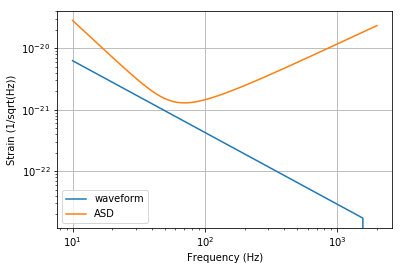

In [24]:
freqs,Sn=calc_noise_psd(params_noise)
hf=calc_ampl(params_signal,freqs)
cut=freqs>calc_fisco(params_signal)
hf[cut]=0

plt.loglog(freqs,hf,label='waveform')
plt.loglog(freqs,np.sqrt(Sn),label='ASD')
plt.legend()
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain (1/sqrt(Hz))')

snr=calc_SNR(params_signal,params_noise,calc_fisco(params_signal))
print('FISCO=%f Hz'%calc_fisco(params_signal))
print('SNR=%f'%snr)

plt.show()

In [25]:
fmax=1000
AA=grad_h(params_signal,freqs,'logA')
BB=grad_h(params_signal,freqs,'logA')
FM_00=NW_IP(AA,BB,params_noise,fmax)
print(FM_00)

99.98841980498487


In [26]:
print('Gamma_1a=',FM[0,:])
print('snr^2=',calc_SNR(params_signal,params_noise,calc_fisco(params_signal))**2)

Gamma_1a= [99.99419115  0.          0.          0.          0.          0.        ]
snr^2= 99.99419114769665


In [27]:
print('Gamma_46(me)=%e'%FM[3,5])

def II(q,params):
    f0=70
    xmin=1/7
    Mtot=calc_Mtot(params)
    xmax=(6**(3/2)*G*np.pi*Mtot*f0/c**3)**(-1)
    dx=0.0001
    x=np.arange(xmin,xmax,dx)
    Iq=np.sum(x**(-q/3)/(x**(-4)+2+2*x**2)*dx)    
    return Iq

def JJ(q,params):
    return II(q,params)/II(7,params)

def snr_PW(params):
    ampl=calc_ampl(params,1)
    S0=(1.3e-21)**2
    f0=70
    snr_PW=np.sqrt(20*ampl**2*S0**(-1)*f0**(-4/3)*II(7,params))
    return snr_PW

Mc=params_signal['Mc']
eta=params_signal['eta']
beta=params_signal['beta']
sigma=params_signal['sigma']

A4=4/3*(743/336+11/4*eta)
B4=8/5*(4*np.pi-beta)
C4=2*(3058673/1016064+5429/1008*eta+617/144*eta**2-sigma) 

f0=70

pre_factor=-15/4096*eta**(-3/5)*(G*np.pi*Mc*f0/c**3)**(-7/3)
sum_J=JJ(14,params_signal)+A4*JJ(12,params_signal)-B4*JJ(11,params_signal)+C4*JJ(10,params_signal)
snr2=snr_PW(params_signal)**2

Gamma_46_PW= pre_factor*sum_J*snr2
print('Gamma_46(PW)=%e'%Gamma_46_PW)

Gamma_46(me)=-1.836358e+07
Gamma_46(PW)=4.249985e+07


In [58]:
means=np.zeros(len(params_fisher))
means[0]=np.log(calc_ampl(params_signal,fref)) # logA
means[1]=0 # f0tc
means[2]=0 # phic
means[3]=np.log(params_signal['Mc']) # logMc
means[4]=np.log(params_signal['eta']) # logeta
means[5]=params_signal['beta'] # beta

cov_matrix=np.linalg.inv(FM)

snr=calc_SNR(params_signal,params_noise,calc_fisco(params_signal))
print('SNR(me)=%f'%snr)

ampl=calc_ampl(params_signal,1)
S0=(1.29563e-21)**2
f0=70
xmin=1/7
Mtot=calc_Mtot(params_signal)
xmax=(6**(3/2)*G*np.pi*Mtot*f0/c**3)**(-1)
dx=0.001
x=np.arange(xmin,xmax,dx)
I7=np.sum(x**(-7/3)/(x**(-4)+2+2*x**2)*dx)
snr_PW=np.sqrt(20*ampl**2*S0**(-1)*f0**(-4/3)*I7)
print('SNR(PW)=%f\n'%snr_PW)

print('theta\tmu\t\tsigma')
print('----------------------------------')
for ii,p in enumerate(params_fisher):
    print('%s\t%f\t%f'%(p,means[ii],np.sqrt(cov_matrix[ii,ii])))
    
def corr_coeff(cov_matrix,ii,jj):
    return cov_matrix[ii-1,jj-1]/np.sqrt(cov_matrix[ii-1,ii-1]*cov_matrix[jj-1,jj-1])

cov_matrix=np.linalg.inv(FM)
c_45=corr_coeff(cov_matrix,4,5)
c_46=corr_coeff(cov_matrix,4,6)
c_56=corr_coeff(cov_matrix,5,6)

print('\n')

print('Compare with Tabe II, row 2 of gr-qc/9502040')
f0=calc_fisco(params_signal)
print('Dtc\t%f ms\nDphic\t%f rad\nDMc/Mc\t%f%%\nDH/H\t%f\nDbeta\t%f\nc45\t%f\nc46\t%f\nc56\t%f'%(np.sqrt(cov_matrix[1,1])/f0*1000, # tc
                       np.sqrt(cov_matrix[2,2]), # phic
                       np.sqrt(cov_matrix[3,3])*100, # Mc
                       np.sqrt(cov_matrix[4,4]),  # eta
                       np.sqrt(cov_matrix[5,5]),  # beta
                       c_45,c_46,c_56
     ))

SNR(me)=9.999710
SNR(PW)=10.000003

theta	mu		sigma
----------------------------------
logA	-47.323731	0.100003
f0tc	0.000000	1.684935
phic	0.000000	2.963567
logMc	69.968543	0.000367
logeta	-1.386294	0.283180
beta	0.000000	1.353504


Compare with Tabe II, row 2 of gr-qc/9502040
Dtc	1.076242 ms
Dphic	2.963567 rad
DMc/Mc	0.036748%
DH/H	0.283180
Dbeta	1.353504
c45	-0.989480
c46	0.993990
c56	-0.999269


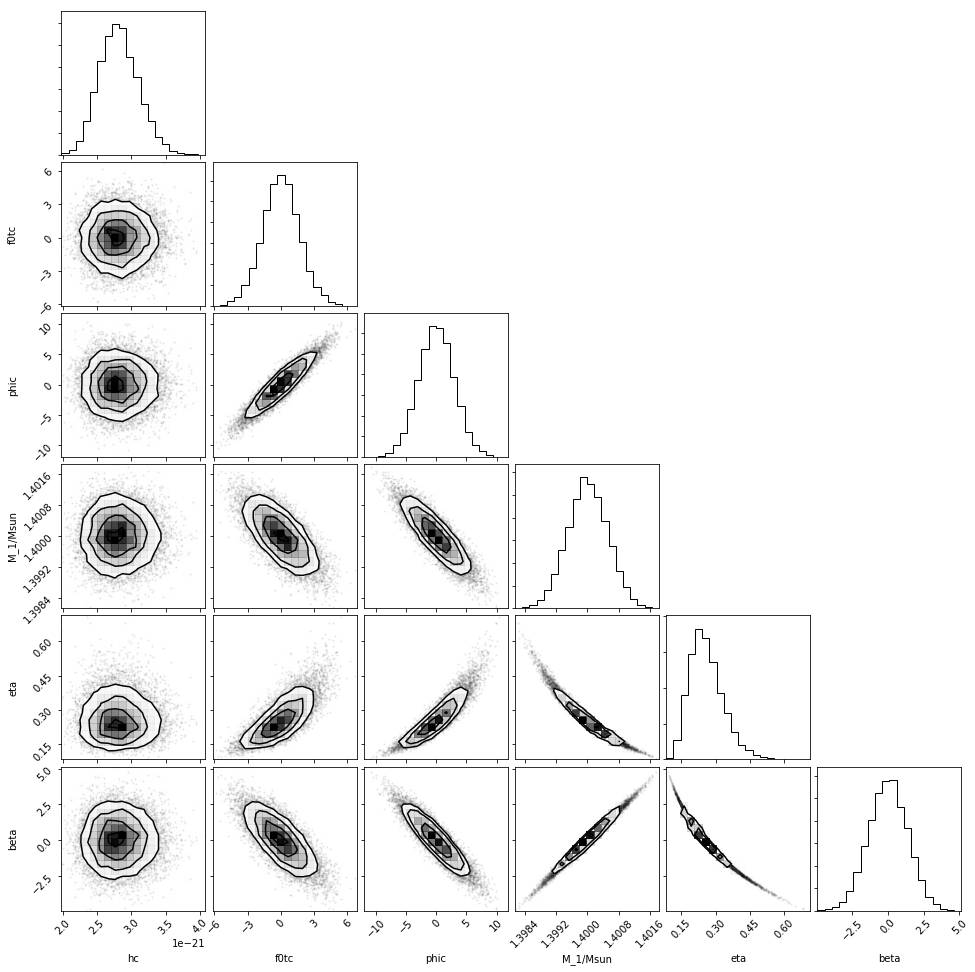

In [34]:
Nsamples=10000

fref=20
means=np.zeros(len(params_fisher))
means[0]=np.log(calc_ampl(params_signal,fref)) # logA
means[1]=0 # f0tc
means[2]=0 # phic
means[3]=np.log(params_signal['Mc']) # logMc
means[4]=np.log(params_signal['eta']) # logeta
means[5]=params_signal['beta'] # beta

cov_matrix=np.linalg.inv(FM)

samples=draw_samples_Gaussian(cov_matrix,means=means,Nsamples=Nsamples)

# correct samples -- ie change units to convenient values
samples_corr=samples
samples_corr[0,:]=np.exp(samples[0,:])
samples_corr[3,:]=np.exp(samples[3,:])/Msolar * eta**(-3/5)/2
samples_corr[4,:]=np.exp(samples[4,:])

params_fisher_corr=['hc','f0tc','phic','M_1/Msun','eta','beta']

corner.corner(samples_corr.T,labels=params_fisher_corr)
plt.show()